## Basics

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
df = pd.read_csv('US_Heart_Patients.csv')

In [5]:
df.head()

,Gender,age,education,currentSmoker,cigsPerDay,BP Meds,prevalentStroke,prevalentHyp,diabetes,tot cholesterol,Systolic BP,Diastolic BP,BMI,heartRate,glucose,Heart-Att
0,Male,39.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,Female,46.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,Male,48.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,Female,61.0,3.0,1.0,30.0,0.0,0.0,1.0,0.0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,Female,46.0,3.0,1.0,23.0,0.0,0.0,0.0,0.0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           4232 non-null   object 
 1   age              4238 non-null   float64
 2   education        4130 non-null   float64
 3   currentSmoker    4237 non-null   float64
 4   cigsPerDay       4209 non-null   float64
 5   BP Meds          4180 non-null   float64
 6   prevalentStroke  4231 non-null   float64
 7   prevalentHyp     4238 non-null   float64
 8   diabetes         4238 non-null   float64
 9   tot cholesterol  4180 non-null   float64
 10  Systolic BP      4236 non-null   float64
 11  Diastolic BP     4235 non-null   float64
 12  BMI              4216 non-null   float64
 13  heartRate        4236 non-null   float64
 14  glucose          3849 non-null   float64
 15  Heart-Att        4240 non-null   int64  
dtypes: float64(14), int64(1), object(1)
memory usage: 530.1+ KB


## Filling null values

In [7]:
df['age'].fillna(df['age'].mean(), inplace=True)

In [8]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

In [9]:
df['cigsPerDay'].fillna(df['cigsPerDay'].mean(), inplace=True)

In [10]:
to_fill_with_median = ['tot cholesterol', 'Systolic BP', 'Diastolic BP','BMI', 'heartRate', 'glucose']
for col in to_fill_with_median:
    df[col].fillna(df[col].median(), inplace=True)

In [11]:
binary_cols = ['currentSmoker', 'BP Meds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [12]:
for col in binary_cols:
    null_indices = df[df[col].isnull()].index
    num_nulls = len(null_indices)
    random_values = np.random.choice([0, 1], size=num_nulls)
    df.loc[null_indices, col] = random_values

In [13]:
values_to_insert = [1, 2, 3, 4]
null_indices = df[df['education'].isnull()].index
num_each_value = len(null_indices) // len(values_to_insert)
values = values_to_insert * num_each_value

In [14]:
# If there are any remaining null values, add additional values randomly
remaining_values = len(null_indices) - len(values)
if remaining_values > 0:
    values += np.random.choice(values_to_insert, remaining_values).tolist()

# Shuffle the values to insert
np.random.shuffle(values)

# Insert the values into the null positions
df.loc[null_indices, 'education'] = values

In [15]:
# Verify the changes
print(df['education'].isnull().sum())  # Should be 0
print(df['education'].value_counts())

0
education
1.0    1745
2.0    1280
3.0     715
4.0     500
Name: count, dtype: int64




This code will fill the null values in the 'education' column with the values 1, 2, 3, and 4 in equal numbers randomly.

In [16]:
df.duplicated().sum()

0

In [17]:
df.fillna({'Gender': df['Gender'].mode}, inplace=True)

In [18]:
cols_to_convert = ['education', 'currentSmoker', 'BP Meds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [19]:
for col in cols_to_convert:
    df[col] = df[col].astype('int')

## Removing Outliers

In [20]:
X = df.drop('Heart-Att', axis=1)    
y = df['Heart-Att']

In [21]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [22]:
cols_outliers = ['cigsPerDay','tot cholesterol','Systolic BP','Diastolic BP','BMI','heartRate','glucose']

In [23]:
for column in cols_outliers:
    lr,ur=remove_outlier(X[column])
    X[column]=np.where(X[column]>ur,ur,X[column])
    X[column]=np.where(X[column]<lr,lr,X[column])

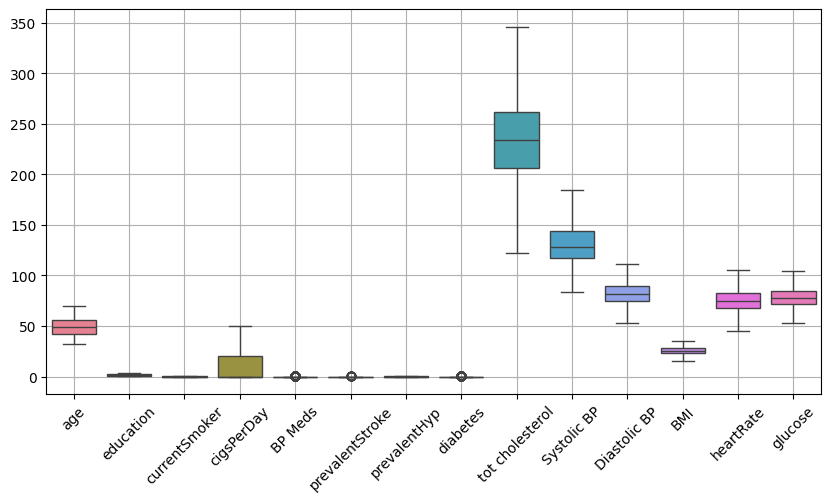

In [24]:
plt.figure(figsize=(10,5))
sns.boxplot(data=X);
plt.grid(True)
plt.xticks(rotation=45);

## Logistic Regression

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [26]:
label_encoder = LabelEncoder()
X['Gender'] = label_encoder.fit_transform(df['Gender'])

In [27]:
print(label_encoder.transform(['Male']))

[1]


In [28]:
X = X.astype('int')

In [60]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=0)

In [62]:
X_test_orig.to_csv('X_test_orig.csv', index=False)

In [63]:
scaler = StandardScaler()
X_train_orig = scaler.fit_transform(X_train_orig)
X_test_orig = scaler.transform(X_test_orig)

In [31]:
df['Heart-Att'].value_counts()  

Heart-Att
0    3596
1     644
Name: count, dtype: int64

In [64]:
model_lr = LogisticRegression()
model_lr.fit(X_train_orig, y_train_orig)

LogisticRegression()

In [65]:
y_pred = model_lr.predict(X_test_orig)

In [66]:
class_report = classification_report(y_test_orig, y_pred)

In [67]:
print(class_report)

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       722
           1       0.92      0.09      0.16       126

    accuracy                           0.86       848
   macro avg       0.89      0.54      0.54       848
weighted avg       0.87      0.86      0.81       848



## Models Loop

In [36]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE

In [37]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(), 
    'Support Vector Machine': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost' : AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'LDA' : LinearDiscriminantAnalysis()
}

In [38]:
results = []

In [39]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    results.append({'Model':model_name, 
                    'Accuracy':accuracy, 
                    'Precision':precision, 
                    'Recall':recall})

In [40]:
results_df = pd.DataFrame(results).round(2)

In [41]:
results_df

,Model,Accuracy,Precision,Recall
0,Logistic Regression,0.86,0.92,0.09
1,Random Forest,0.85,0.50,0.04
2,Decision Tree,0.76,0.18,0.17
3,K-Nearest Neighbors,0.85,0.43,0.13
4,Support Vector Machine,0.85,0.40,0.02
5,Gradient Boosting,0.85,0.43,0.05
6,AdaBoost,0.86,0.69,0.09
7,Naive Bayes,0.83,0.37,0.25
8,LDA,0.86,0.85,0.09


## Lowering Thresholds

In [42]:
results_threshold = []

In [43]:

threshold = 0.3

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    y_pred = (y_pred_proba > threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    results_threshold.append({'Model':model_name, 
                    'Accuracy':accuracy, 
                    'Precision':precision, 
                    'Recall':recall})

In [44]:
results_threshold = pd.DataFrame(results_threshold).round(2)
results_threshold

,Model,Accuracy,Precision,Recall
0,Logistic Regression,0.81,0.32,0.23
1,Random Forest,0.81,0.34,0.31
2,Decision Tree,0.76,0.18,0.17
3,K-Nearest Neighbors,0.77,0.26,0.29
4,Support Vector Machine,0.85,0.54,0.12
5,Gradient Boosting,0.82,0.34,0.22
6,AdaBoost,0.15,0.15,1.00
7,Naive Bayes,0.80,0.31,0.26
8,LDA,0.81,0.32,0.23


In [45]:
comparison_df = pd.concat([results_df, results_threshold], axis=1)
# comparison_df.columns = ['Model', 'Accuracy_Default','Accuracy_Threshold', 'Precision_Default','Model','Precision_Threshold', \
    # 'Recall_Default', 'Recall_Threshold']

comparison_df

,Model,Accuracy,Precision,Recall,Model,Accuracy,Precision,Recall
0,Logistic Regression,0.86,0.92,0.09,Logistic Regression,0.81,0.32,0.23
1,Random Forest,0.85,0.50,0.04,Random Forest,0.81,0.34,0.31
2,Decision Tree,0.76,0.18,0.17,Decision Tree,0.76,0.18,0.17
3,K-Nearest Neighbors,0.85,0.43,0.13,K-Nearest Neighbors,0.77,0.26,0.29
4,Support Vector Machine,0.85,0.40,0.02,Support Vector Machine,0.85,0.54,0.12
5,Gradient Boosting,0.85,0.43,0.05,Gradient Boosting,0.82,0.34,0.22
6,AdaBoost,0.86,0.69,0.09,AdaBoost,0.15,0.15,1.00
7,Naive Bayes,0.83,0.37,0.25,Naive Bayes,0.80,0.31,0.26
8,LDA,0.86,0.85,0.09,LDA,0.81,0.32,0.23


## SMOTE

In [46]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y) 

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)

In [48]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
results_smote = []

In [50]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    results_smote.append({'Model':model_name, 
                    'Accuracy':accuracy, 
                    'Precision':precision, 
                    'Recall':recall})

In [51]:
results_smote = pd.DataFrame(results_smote).round(2)
results_smote

,Model,Accuracy,Precision,Recall
0,Logistic Regression,0.68,0.69,0.68
1,Random Forest,0.89,0.88,0.91
2,Decision Tree,0.79,0.78,0.81
3,K-Nearest Neighbors,0.78,0.73,0.90
4,Support Vector Machine,0.75,0.74,0.77
5,Gradient Boosting,0.76,0.76,0.78
6,AdaBoost,0.72,0.72,0.76
7,Naive Bayes,0.64,0.65,0.62
8,LDA,0.68,0.69,0.68


In [52]:
comparison_df = pd.concat([results_threshold, results_smote], axis=1)
comparison_df

,Model,Accuracy,Precision,Recall,Model,Accuracy,Precision,Recall
0,Logistic Regression,0.81,0.32,0.23,Logistic Regression,0.68,0.69,0.68
1,Random Forest,0.81,0.34,0.31,Random Forest,0.89,0.88,0.91
2,Decision Tree,0.76,0.18,0.17,Decision Tree,0.79,0.78,0.81
3,K-Nearest Neighbors,0.77,0.26,0.29,K-Nearest Neighbors,0.78,0.73,0.90
4,Support Vector Machine,0.85,0.54,0.12,Support Vector Machine,0.75,0.74,0.77
5,Gradient Boosting,0.82,0.34,0.22,Gradient Boosting,0.76,0.76,0.78
6,AdaBoost,0.15,0.15,1.00,AdaBoost,0.72,0.72,0.76
7,Naive Bayes,0.80,0.31,0.26,Naive Bayes,0.64,0.65,0.62
8,LDA,0.81,0.32,0.23,LDA,0.68,0.69,0.68


## Selected Model

In [53]:
model_rf = RandomForestClassifier(random_state=42)

In [54]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [55]:
y_pred = model_rf.predict(X_test)

In [56]:
from sklearn.metrics import classification_report

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       710
           1       0.88      0.91      0.89       729

    accuracy                           0.89      1439
   macro avg       0.89      0.89      0.89      1439
weighted avg       0.89      0.89      0.89      1439



In [69]:
feature_importances = pd.DataFrame({
    'Feature': X_res.columns,
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances

,Feature,Importance
1,age,0.154977
10,Systolic BP,0.132511
9,tot cholesterol,0.126606
13,heartRate,0.107746
14,glucose,0.104547
11,Diastolic BP,0.102326
4,cigsPerDay,0.079981
12,BMI,0.079238
2,education,0.048090
3,currentSmoker,0.022205


## Exporting the Model

In [58]:
import pickle

In [59]:
pickle_out = open("heart_attack_model.pkl", "wb")
pickle.dump(model_rf, pickle_out)